<a href="https://colab.research.google.com/github/dayyaanjattiem/Python-and-ML-and-DL-course/blob/main/Technical_and_Financial_Analysis_of_Listed_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [23]:
# Function to calculate RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.iloc[-1] if not rsi.isna().all() else np.nan

In [27]:
# Fetch stock data from Yahoo Finance
tickers = ["AAPL", "GOOGL", "MSFT", "TSLA"]
data = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")

    # Avoid errors if data is missing
    if hist.empty:
        print(f"Warning: No data available for {ticker}")
        continue

    pe_ratio = stock.info.get('forwardPE', np.nan)
    eps = stock.info.get('trailingEps', np.nan)
    volume = hist['Volume'].mean() if not hist['Volume'].isna().all() else np.nan
    moving_avg = hist['Close'].rolling(window=50).mean().iloc[-1] if len(hist) >= 50 else np.nan
    market_cap = stock.info.get('marketCap', np.nan)
    rsi = calculate_rsi(hist['Close'])

    data.append({
        'PE_Ratio': pe_ratio,
        'EPS': eps,
        'Volume': volume,
        'RSI': rsi,
        'Moving_Avg': moving_avg,
        'Market_Cap': market_cap,
        'Buy_Signal': np.random.choice([0, 1])  # Placeholder target variable
    })

In [28]:
df = pd.DataFrame(data).dropna()  # Drop rows with NaN values

if df.empty:
    raise ValueError("No valid stock data available. Please check the ticker.")

# Define features and target
features = ['PE_Ratio', 'EPS', 'Volume', 'RSI', 'Moving_Avg', 'Market_Cap']
target = 'Buy_Signal'

X = df[features].values
y = df[target].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [9]:
# Build ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save("stock_screening_ann.h5")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 0.8949 - val_accuracy: 1.0000 - val_loss: 0.6412
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.2500 - loss: 0.8723 - val_accuracy: 1.0000 - val_loss: 0.6475
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2500 - loss: 0.9533 - val_accuracy: 1.0000 - val_loss: 0.6474
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0000e+00 - loss: 0.9422 - val_accuracy: 1.0000 - val_loss: 0.6426
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2500 - loss: 0.9562 - val_accuracy: 1.0000 - val_loss: 0.6357
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2500 - loss: 0.8519 - val_accuracy: 1.0000 - val_loss: 0.6295
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5000 - loss: 0.8562 - val_accuracy: 1.0000 - val_loss: 0.6240
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2500 - loss: 0.7884 - val_accuracy: 1.0000 - val_loss: 0

Test Accuracy: 100.00%


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

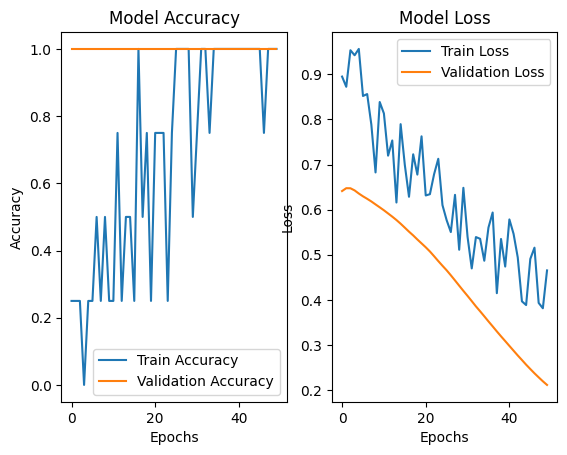

In [11]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [12]:
# ---- STOCK SCREENING ----

# Load the trained model
model = keras.models.load_model('stock_screening_ann.h5')

# Example stock tickers to screen
tickers = ["AAPL", "GOOGL", "MSFT"]
feature_data = []
visual_data = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")

    if hist.empty:
        print(f"Warning: No data available for {ticker}")
        continue

    # Extract features
    pe_ratio = stock.info.get('forwardPE', np.nan)
    eps = stock.info.get('trailingEps', np.nan)
    volume = hist['Volume'].mean() if not hist['Volume'].isna().all() else np.nan
    moving_avg = hist['Close'].rolling(window=50).mean().iloc[-1] if len(hist) >= 50 else np.nan
    market_cap = stock.info.get('marketCap', np.nan)
    rsi = calculate_rsi(hist['Close'])

    # Store data
    visual_data[ticker] = {
        'PE_Ratio': pe_ratio, 'EPS': eps, 'Volume': volume,
        'RSI': rsi, 'Moving_Avg': moving_avg, 'Market_Cap': market_cap
    }

    feature_data.append([pe_ratio, eps, volume, rsi, moving_avg, market_cap])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
AAPL: Do Not Buy (Prediction: 0.44)
GOOGL: Do Not Buy (Prediction: 0.43)
MSFT: Do Not Buy (Prediction: 0.42)


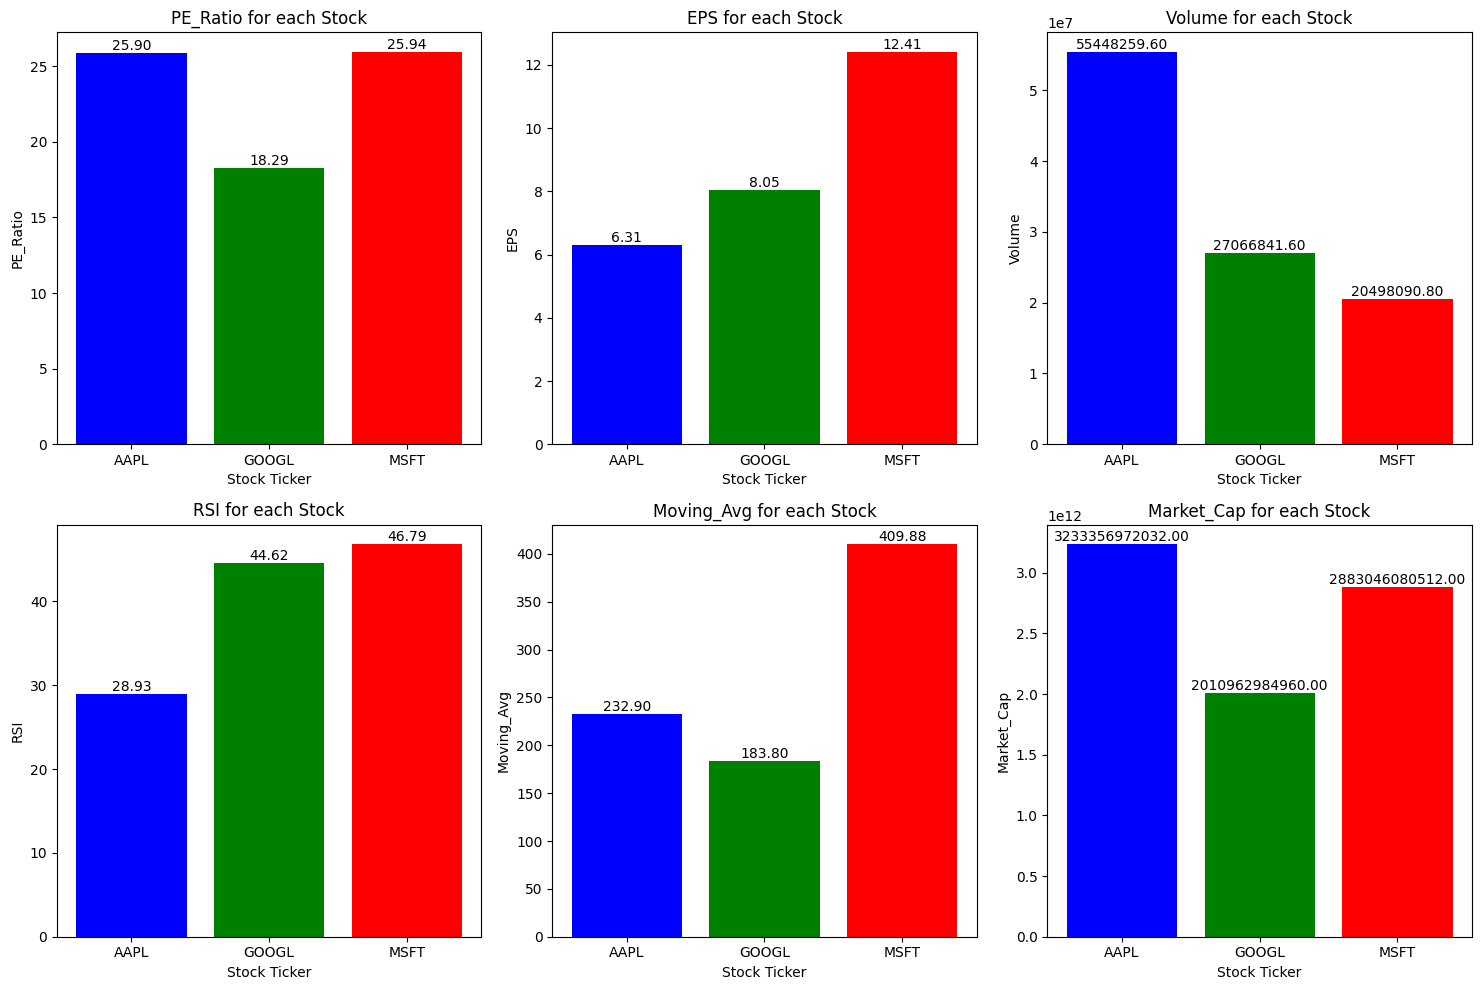

In [15]:
# Convert feature list to NumPy array
feature_data = np.array(feature_data)

# Normalize features using the same scaler
if feature_data.shape[0] > 0:
    feature_data = scaler.transform(feature_data)
else:
    raise ValueError("No valid stock features available for screening.")

# Predict buy signals
predictions = model.predict(feature_data).flatten()

# Output results
for ticker, prediction in zip(visual_data.keys(), predictions):
    recommendation = "Buy" if prediction > 0.5 else "Do Not Buy"
    print(f"{ticker}: {recommendation} (Prediction: {prediction:.2f})")

# Plot stock features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

feature_names = ['PE_Ratio', 'EPS', 'Volume', 'RSI', 'Moving_Avg', 'Market_Cap']

axes = axes.flatten()
for i, feature in enumerate(feature_names):
    ax = axes[i]
    values = [visual_data[ticker][feature] for ticker in visual_data.keys()]
    ax.bar(visual_data.keys(), values, color=['blue', 'green', 'red'])
    ax.set_title(f"{feature} for each Stock")
    ax.set_ylabel(feature)
    ax.set_xlabel("Stock Ticker")

    for j, value in enumerate(values):
        ax.text(j, value, f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>